In [1]:
#import models
import numpy as np
import h5py
import sys, os
import rospy
import rosbag
import math
from scipy.interpolate import interp1d
import h5py
import matplotlib.pylab as plt

from EventPreProcess import EventPreProcess
from dvs_msgs.msg import EventArray
from std_msgs.msg import Float64, Bool
from geometry_msgs.msg import Pose, Vector3, PoseStamped

ImportError: No module named dvs_msgs.msg

In [19]:
bag_file = rosbag.Bag('tactile_sensing_data/2020-08-18-14-09-04.bag')

events = []
contact_status = []
contact_status_ts = []
contact_case = [] #0:No contact 1: center, 2:remainder of contacts as in list_of_rotations
contact_case_ts = []

list_of_rotations = [[0,0,0], [0.2, 0, 0], [0, 0.2, 0], [-0.2, 0, 0], [0, -0.2, 0]]


for topic, msg, t in bag_file.read_messages(topics=['/contact_status', '/dvs/events', '/contact_angle']):
    if topic == '/dvs/events':
        for e in msg.events:
            event = [e.x, e.y, e.ts.to_nsec(), e.polarity]
            events.append(event)
    elif topic == '/contact_status':
        contact_status.append(msg.data)
        contact_status_ts.append(t.to_nsec())
    elif topic == '/contact_angle':
        if (len(contact_status) > 1):
            if (contact_status[-1] == True):
                best_rot_diff = 100
                best_rot_idx = 1
                i = 1
                for rot in list_of_rotations:
                    diff_vals = np.sqrt( np.power(rot[0] - msg.x, 2) +  np.power(rot[1] - msg.y, 2) + np.power(rot[2] - msg.z, 2) )
                    if best_rot_diff > diff_vals:
                        best_rot_diff = diff_vals
                        best_rot_idx = i
                    i = i + 1

                contact_case.append(best_rot_idx)
                contact_case_ts.append(t.to_nsec())
            else:
                contact_case.append(0)
                contact_case_ts.append(t.to_nsec())
        else:
            contact_case.append(0)
            contact_case_ts.append(t.to_nsec())

In [20]:
#interpolate

f = interp1d(contact_case_ts, contact_case, kind='previous')
contact_case_ts_int = range(min(contact_case_ts), max(contact_case_ts), int(0.03*1e9))
contact_case_int = f(contact_case_ts_int)

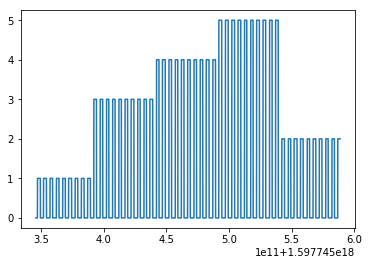

8106


In [21]:

plt.plot(contact_case_ts_int, contact_case_int)
plt.show()
print(len(contact_case_ts_int))

In [22]:

hf = h5py.File('event_frame_data.hdf5', 'w')
hf.create_dataset('contact_status', data=contact_case_int)
hf.create_dataset('time_steps', data=contact_case_ts_int)

set_size = 3000
unprocessed_events = np.copy(events)

for i in range(0, len(contact_case_ts_int), set_size):
    start_idx=i
    end_idx=min([len(contact_case_ts_int), i+set_size])

    [event_frames, unprocessed_events] = EventPreProcess.ConcatenateEvents(unprocessed_events, contact_case_ts_int[start_idx:end_idx])
    #write data
    if i==0:
        hf.create_dataset('event_images', data=event_frames, maxshape=(None,None, None, None))
    else:
        hf['event_images'].resize(len(hf['event_images']) + len(event_frames), axis=0)
        hf["event_images"][-len(event_frames):] = event_frames
    del event_frames

hf.close()

Percentage finished: 0.0
Percentage finished: 0.0
Percentage finished: 44.7475916207
Percentage finished: 0.0


ValueError: Invalid mode; must be one of r, r+, w, w-, x, a

In [23]:
def create_dataset(hf_file, time_steps=50, n_classes=6):
    for i in range(time_steps, len(hf_file['event_images']) - time_steps):
        if (i%1000) == 0:
            print(i/float(len(hf_file['event_images'])))
        reference_idx = range(i-time_steps+1,i+1)
        one_hot_vector = [0] * n_classes
        one_hot_vector[int(hf_file['contact_status'][i])] = 1
        
        if i==time_steps:
            hf_file.create_dataset('event_image_sequense', data=[reference_idx], maxshape=(None,None))
            hf_file.create_dataset('ref_class', data=[one_hot_vector], maxshape=(None, None))
        else:
            hf_file['event_image_sequense'].resize(len(hf_file['event_image_sequense']) + 1, axis=0)
            hf_file["event_image_sequense"][len(hf_file['event_image_sequense'])-1] = reference_idx

            hf_file['ref_class'].resize(len(hf_file['ref_class']) + 1, axis=0)
            hf_file["ref_class"][len(hf_file['ref_class'])-1] = one_hot_vector

In [24]:
hf = h5py.File('event_frame_data.hdf5', 'r+')
create_dataset(hf)

0.12336540834
0.246730816679
0.370096225019
0.493461633358
0.616827041698
0.740192450037
0.863557858377
0.986923266716


In [25]:
hf.close()


In [3]:

hf = h5py.File('event_frame_data.hdf5', 'r+')

In [27]:
print(np.random.rand())

0.53441365032


[4584, 659, 647, 692, 706, 718]


<Container object of 6 artists>

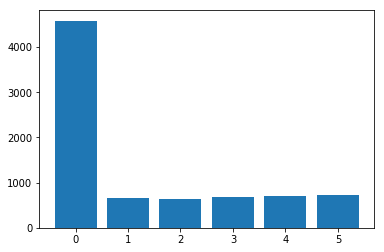

In [4]:
#analyze classes

counter = [0] * 6

for i in range(len(hf['ref_class'])):
    idx = list(hf['ref_class'][i]).index(1)
    counter[idx] = counter[idx] + 1

print(counter)
plt.bar(range(0,6),counter)


In [29]:
print(counter[hf['ref_class'][1]])

SyntaxError: invalid syntax (<ipython-input-29-424a90fdbc04>, line 1)

In [30]:
def normalize_representation(hf_file, class_counter, n_classes=6):
    for i in range(len(hf_file['ref_class'])):
        idx = list(hf['ref_class'][i]).index(1)
        
        if (np.random.rand() < (float(min(counter)) / counter[idx])):
            if 'normalized_ref_class' in hf_file.keys():
                hf_file['normalized_event_image_sequense'].resize(len(hf_file['normalized_event_image_sequense']) + 1, axis=0)
                hf_file["normalized_event_image_sequense"][len(hf_file['normalized_event_image_sequense'])-1] = hf_file['event_image_sequense'][i]

                hf_file['normalized_ref_class'].resize(len(hf_file['normalized_ref_class']) + 1, axis=0)
                hf_file["normalized_ref_class"][len(hf_file['normalized_ref_class'])-1] = hf['ref_class'][i]
            else:
                hf_file.create_dataset('normalized_event_image_sequense', data=[hf_file['event_image_sequense'][i]], maxshape=(None,None))
                hf_file.create_dataset('normalized_ref_class', data=[hf_file['ref_class'][i]], maxshape=(None, None))

normalize_representation(hf, counter)

[618, 651, 647, 650, 639, 635]


<Container object of 6 artists>

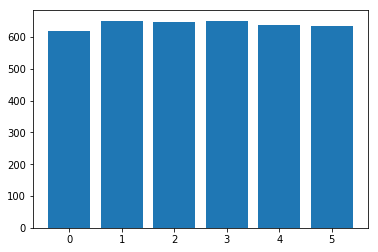

In [5]:
new_counter = [0] * 6

for i in range(len(hf['normalized_ref_class'])):
    idx = list(hf['normalized_ref_class'][i]).index(1)
    new_counter[idx] = new_counter[idx] + 1

print(new_counter)
plt.bar(range(0,6),new_counter)

In [32]:
print(len(hf['normalized_ref_class']))

3840


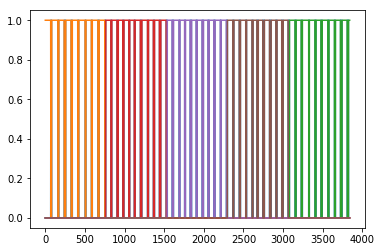

In [33]:
print(np.mean(hf['event_images'][:,:,:,0]))
print(np.std(hf['event_images'][:,:,:,0]))
print(np.max(hf['event_images'][:,:,:,0]))
print(np.min(hf['event_images'][:,:,:,0]))


0.0008835273
0.031460017
21.0
0.0


In [34]:
print(hf.keys())

if 'contact_status' in hf.keys():
    print('yes')
else:
    print('no')

[u'contact_status', u'event_image_sequense', u'event_images', u'normalized_event_image_sequense', u'normalized_ref_class', u'ref_class', u'time_steps']
yes


In [35]:
hf.close()